# Comparing the PanAntarctics

In [1]:
import pandas as pd
from scipy.signal import detrend

import gsw
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40875,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45781,Total threads: 1
Dashboard: /proxy/38309/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42363,


### Importing the data

In [4]:
pan005_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan005.nc', chunks = 'auto')
pan01_bottemp_anom = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_CT_pan01.nc', chunks = 'auto')

In [12]:
pan01_bottemp_anom_new = pan01_bottemp_anom.to_series()

In [13]:
pan005_bottemp_anom_new = pan005_bottemp_anom.to_series()

In [14]:
# Slice 1910–1919 and 2001–2010
pan005_bottemp_anom_new = pan005_bottemp_anom_new['2001-01-01':'2010-12-31']
pan01_bottemp_anom_new = pan01_bottemp_anom_new['2001-01-01':'2010-12-31']

# Reset index to normalized months
pan005_bottemp_anom_new.index = range(1, len(pan005_bottemp_anom_new)+1)
pan01_bottemp_anom_new.index = range(1, len(pan01_bottemp_anom_new)+1)

### Doing a stat analysis

In [15]:
# Example: temp_anom is a pandas Series indexed by time (monthly)
temp_anom = pan01_bottemp_anom_new

# Step 1: Detrend the series
temp_anom_detrended = pd.Series(detrend(temp_anom), index=temp_anom.index)
temp_anom_detrended

# Step 2: Smooth with 10-year running mean (for monthly data, window=120)
running_mean = temp_anom_detrended.rolling(window=118, center=True, min_periods=1).mean()
running_mean

1      0.000649
2      0.000495
3      0.000304
4      0.000090
5     -0.000104
         ...   
116   -0.001012
117   -0.000893
118   -0.000757
119   -0.000627
120   -0.000495
Length: 120, dtype: float64

In [16]:
# Step 3: Calculate natural variability residual
natural_variability = temp_anom_detrended - running_mean

# Step 4: Calculate standard deviation of natural variability (ignoring NaNs)
std_nat_var = natural_variability.std()

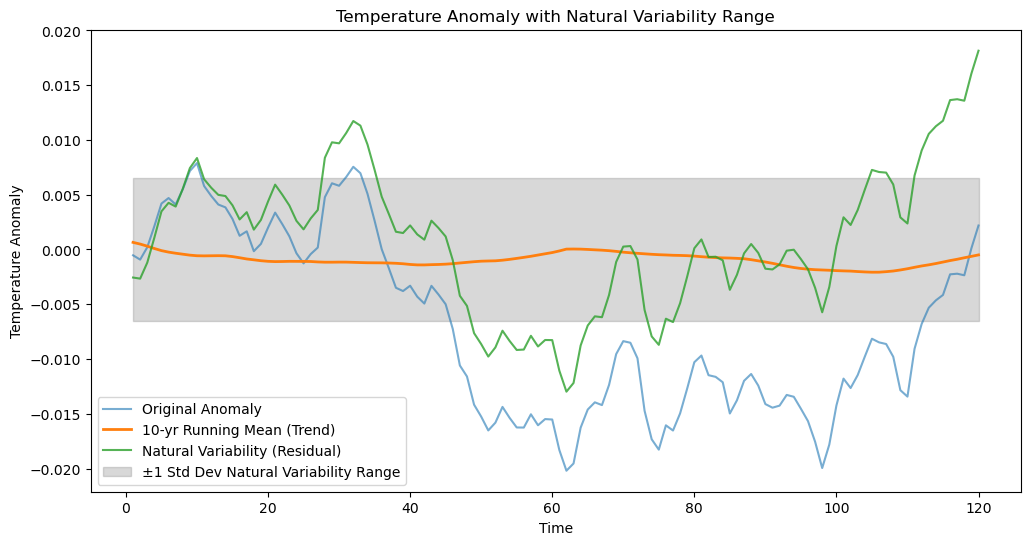

In [17]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(temp_anom.index, temp_anom, label='Original Anomaly', alpha=0.6)
plt.plot(running_mean.index, running_mean, label='10-yr Running Mean (Trend)', linewidth=2)
plt.plot(natural_variability.index, natural_variability, label='Natural Variability (Residual)', alpha=0.8)

# Add shaded region for ±1 std dev of natural variability
plt.fill_between(
    natural_variability.index,
    -std_nat_var,
    std_nat_var,
    color='gray',
    alpha=0.3,
    label='±1 Std Dev Natural Variability Range'
)

plt.legend()
plt.title("Temperature Anomaly with Natural Variability Range")
plt.xlabel("Time")
plt.ylabel("Temperature Anomaly")
plt.show()


### Regular time series

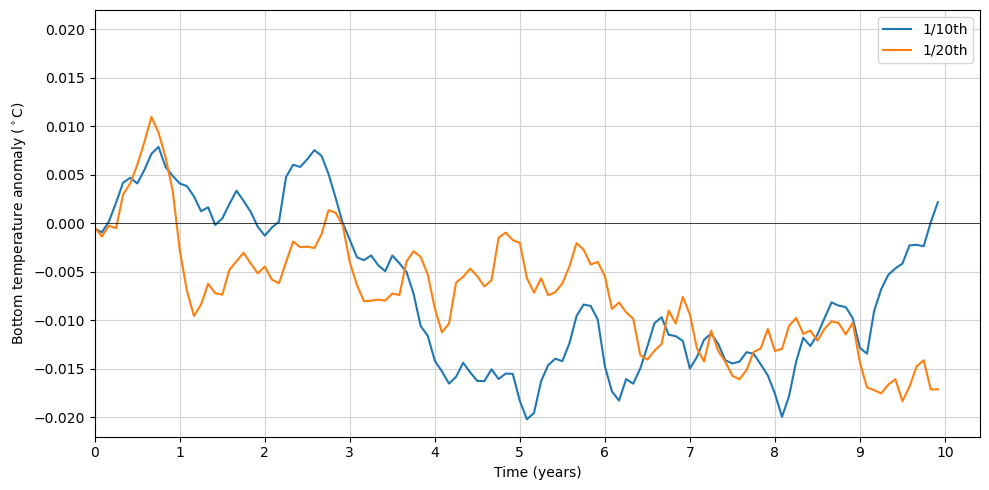

In [28]:
# Make month index start at 0
pan01_bottemp_anom_new.index = range(len(pan01_bottemp_anom_new))
pan005_bottemp_anom_new.index = range(len(pan005_bottemp_anom_new))

plt.figure(figsize=(10, 5))
plt.plot(pan01_bottemp_anom_new.index, pan01_bottemp_anom_new.values, label='1/10th')
plt.plot(pan005_bottemp_anom_new.index, pan005_bottemp_anom_new.values, label='1/20th')

# X-axis: ticks every 12 months, labeled as years from 0 to 10
plt.xticks(ticks=range(0, 121, 12), labels=[str(i) for i in range(0, 11)])

# Add shaded region for ±1 std dev of natural variability
#plt.fill_between(natural_variability.index, -std_nat_var, std_nat_var,
    #color='lightblue', alpha=0.3, label='±1 Std Dev Natural Variability Range for Pan 1/10th')

plt.xlabel('Time (years)')
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
#plt.title('Bottom temperature anomaly, shelf only')
plt.ylim(-0.022, 0.022)
plt.xlim(0,None)
plt.legend()
plt.grid(True, color='lightgrey')
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### 12-month running mean

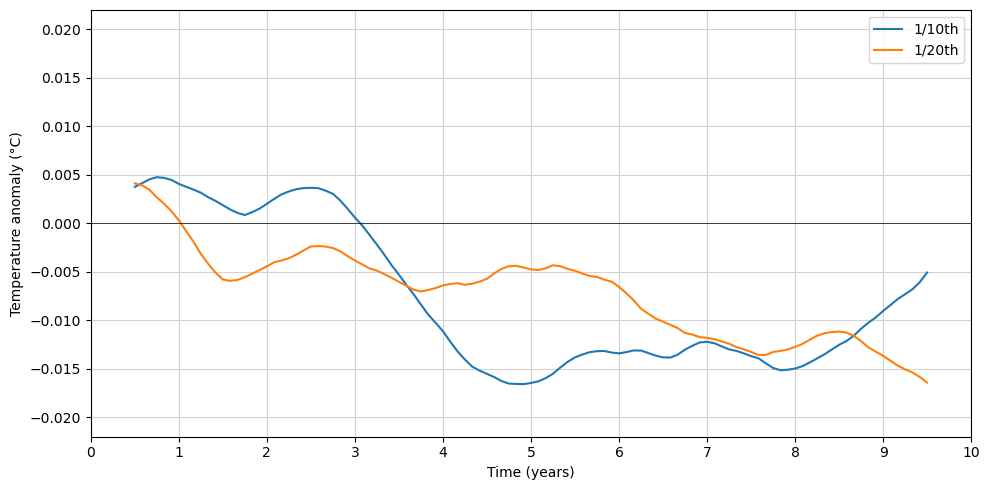

In [29]:
import matplotlib.pyplot as plt

# Compute 12-month running mean (for pandas Series)
pan005_bottemp_rm = pan005_bottemp_anom_new.rolling(window=12, center=True).mean()
pan01_bottemp_rm = pan01_bottemp_anom_new.rolling(window=12, center=True).mean()

# Plot
plt.figure(figsize=(10,5))

plt.plot(pan01_bottemp_rm.index, pan01_bottemp_rm, label='1/10th')
plt.plot(pan005_bottemp_rm.index, pan005_bottemp_rm, label='1/20th')

# X-axis: ticks every 12 months, labeled as years from 0 to 10
plt.xticks(ticks=range(0, 121, 12), labels=[str(i) for i in range(0, 11)])

plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (°C)')
#plt.title('12-month Running Mean of Bottom Temperature Anomalies')
plt.ylim(-0.022, 0.022)
plt.xlim(0,None)
plt.legend()
plt.grid(True, color='lightgrey')
plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()
